In [12]:
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import numpy as np
repo_path = '/Users/ehsan/Desktop/NFL_prediction/'


In [2]:
dataset = pd.read_csv(repo_path+'datasets/train.csv')
dataset.loc[dataset.FieldPosition == 'ARZ', 'FieldPosition'] = 'ARI'

/Users/ehsan/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(dataset[:2].transpose())

                                               0                         1
GameId                                2017090700                2017090700
PlayId                            20170907000118            20170907000118
Team                                        away                      away
X                                          73.91                     74.67
Y                                          34.84                     32.64
S                                           1.69                      0.42
A                                           1.13                      1.35
Dis                                          0.4                      0.01
Orientation                                81.99                     27.61
Dir                                       177.18                     198.7
NflId                                     496723                   2495116
DisplayName                           Eric Berry              Allen Bailey
JerseyNumber             

### Finding the number of observation per feature and average yard 
One of the items that might has an impact on the yards could be defense team positional group. Let's see how many different positions a team can stay:

In [4]:
def plot_feature_yard(feature_name):
    defense_counts = pd.DataFrame.from_dict(Counter(dataset[feature_name]), orient='index').reset_index()
    defense_yard = dataset[[feature_name, 'Yards']].groupby(feature_name).mean().reset_index()
    defense_info = pd.merge(defense_counts, defense_yard, how='inner', left_on=['index'], right_on=[feature_name]).drop('index', axis=1).rename(columns={0:'freq'})
    plt.figure(figsize=(15, 4))
    defense_info.plot(x = feature_name, y = 'freq', kind = 'bar', figsize=(15, 4))
    defense_info['Yards'].plot(secondary_y = True, rot = 90)
plot_feature_yard('Stadium')

### Visualizing the missing value pattern

In [ ]:
fig, ax = plt.subplots(figsize=(14.5,5))
sns.heatmap(dataset.isnull(), cbar = False, ax = ax)

### Correlation between variables


In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
corr = dataset.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


### Data Cleaning and imputation
We can idnetify the unique part of the game by grouping by GameId and TimeSnap and since the max and minimum of the group by is 22 (equal to the total number of players) it could be a unique identifier

In [5]:
unique_play = dataset.groupby(['GameId', 'TimeSnap']).count()[['PlayId']].reset_index()
assert unique_play.PlayId.min() == unique_play.PlayId.max()

### Displaying a situation

The game is selected is with Id 2017111902 and snap 2017-11-19T20:27:53.000Z
Home team ['GB'] Feild Position ['BLT'] Possession Team ['BLT'] Down [1] Move: ['left'] Yard moved [5]
YardLine 66 yard_to_down 56


/Users/ehsan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


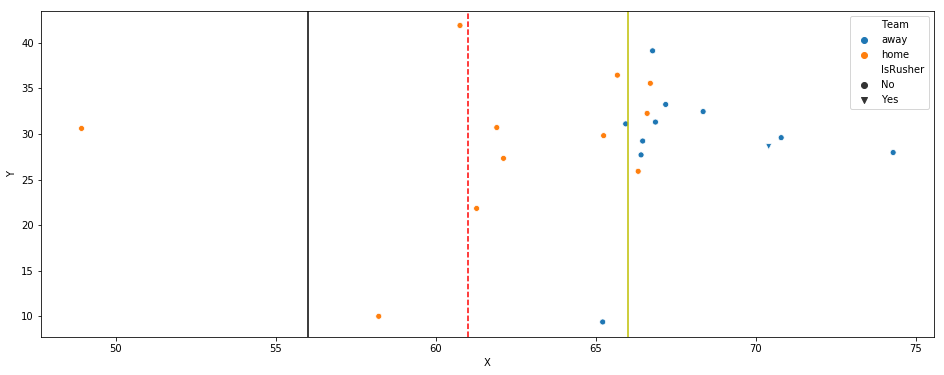

In [24]:
GameId = dataset.GameId.sample().values[0]
TimeSnap = dataset[dataset.GameId == GameId]['TimeSnap'].sample().values[0]
def plot_field(GameId, TimeSnap):
    filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '+', '-')
    plt.figure(figsize=(16, 6))
    print('The game is selected is with Id', GameId, 'and snap', TimeSnap)
    game_data = dataset[(dataset.GameId == GameId) & (dataset.TimeSnap == TimeSnap)]
    game_data['IsRusher'] = np.where(game_data.NflIdRusher == game_data.NflId, 'Yes', 'No')
#     print(game_data.columns)
    sns.scatterplot(x = 'X', 
                   y = 'Y',
                   data = game_data,
                   hue = 'Team',
                   style = 'IsRusher',
                   markers = filled_markers)
    YardLine = game_data.reset_index().YardLine[0] + 10 # The first 10 yard is the touch down area
    if (game_data.PossessionTeam.unique() != game_data.FieldPosition.unique() and game_data.PlayDirection.unique()[0] == 'right') or \
    (game_data.PossessionTeam.unique() == game_data.FieldPosition.unique() and game_data.PlayDirection.unique()[0] == 'left'):
        YardLine = 110 - game_data.reset_index().YardLine[0]
    # CenterPosition = game_data[game_data.Position == 'C']['X'].values[0]
    if game_data.PlayDirection.unique()[0] == 'right':
        Yard10 = YardLine + game_data.Distance.unique()[0]
        DownPosition = YardLine + game_data.Yards.unique()[0]
    else:
        Yard10 = YardLine - game_data.Distance.unique()[0]
        DownPosition = YardLine - game_data.Yards.unique()[0]
    print("Home team", game_data.HomeTeamAbbr.unique(), "Feild Position", game_data.FieldPosition.unique(), "Possession Team", game_data.PossessionTeam.unique(), "Down", game_data.Down.unique(),
         'Move:', game_data.PlayDirection.unique(), "Yard moved", game_data.Yards.unique())
    print('YardLine', YardLine, 'yard_to_down', Yard10)
    plt.axvline(YardLine, 0, 50, color = 'y')
    plt.axvline(Yard10, 0, 50, color = 'k')
    plt.axvline(DownPosition, 0, 50, color = 'r', linestyle = '--')
    plt.show()
    # plt.axvline(CenterPosition, 0, 50, color = 'orange')
plot_field(GameId, TimeSnap)

In [18]:
GameStrategy = dataset.groupby(['GameId', 'TimeSnap']).Position.value_counts().unstack(fill_value = 0)
no_qb = GameStrategy[GameStrategy.QB == 0]
# Games with no quarter back
no_qb

,Position,C,CB,DB,DE,DL,DT,FB,FS,G,HB,...,OLB,OT,QB,RB,S,SAF,SS,T,TE,WR
GameId,TimeSnap,,,,,,,,,,,,,,,,,,,,,
2017092410,2017-09-24T22:22:44.000Z,1,2,0,1,0,2,0,1,2,0,...,1,0,0,2,0,0,1,2,3,1
2017111208,2017-11-12T21:07:48.000Z,1,2,0,1,0,2,0,1,2,0,...,2,1,0,1,0,0,1,1,2,3


The game is selected is with Id 2017092800 and snap 2017-09-29T04:17:03.000Z
Home team ['GB'] Feild Position ['CHI'] Possession Team ['CHI'] Down [4] Move: ['right'] Yard moved [3]
YardLine 59 yard_to_down 60


/Users/ehsan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


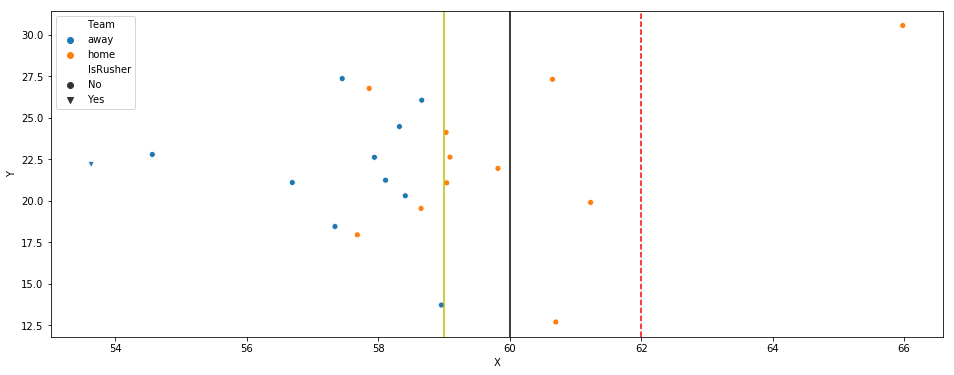

In [23]:
plot_field(GameId = 2017092800, TimeSnap='2017-09-29T04:17:03.000Z')

The game is selected is with Id 2017112600 and snap 2017-11-26T20:04:11.000Z
Home team ['ATL'] Feild Position ['ATL'] Possession Team ['ATL'] Down [1] Move: ['right'] Yard moved [4]
YardLine 59 yard_to_down 69


/Users/ehsan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


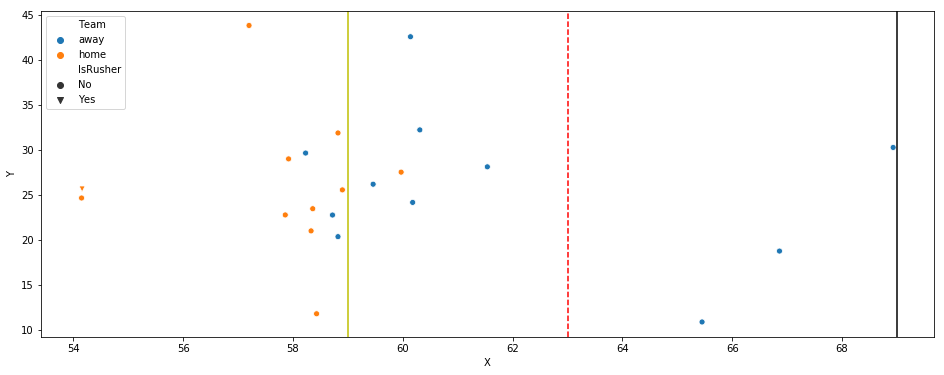

In [28]:
GameId = dataset.GameId.sample().values[0]
TimeSnap = dataset[dataset.GameId == GameId]['TimeSnap'].sample().values[0]

plot_field(GameId, TimeSnap)